In [1]:
%load_ext autoreload
%autoreload 2
#This code is for a SSH 1D CROW network.

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
from matplotlib.pyplot import figure
import math as m
from segment import Segment
from func import *

In [23]:

SIZE = 100
imp0 = 377
xs0 = 50  # source position for the segment 0
kappa_guide = 1j*0.10 #coupling for the waveguide-resonator pair
tau_guide = np.sqrt(1-np.abs(kappa_guide)**2)
kappa_alt = [1j*0.12, 1j*0.24]
# tau_alt#alternate couplings for SSH lattice
tau_alt = np.sqrt(1-np.abs(kappa_alt)**2) # not working yet for complex number

maxTime = 150000
rings_no = 13  #out of N rings defined, 2 will be the input and output port (the first segment will have the source as the only connection; the last segment is redundant, the second last segment will act as the drop port.)
N_seg = rings_no*2

sources = Sources(rings_no)  #working for any number of rings
couplings = SSH_Couplings_1(rings_no, tau_alt, kappa_alt, kappa_guide, tau_guide)

# print(sources)
print(couplings) #starts weak ends strong

ez_tab = np.zeros([N_seg, maxTime, SIZE], dtype=complex)

[[0.99498744+0.j   0.        +0.1j ]
 [0.99498744+0.j   0.        +0.1j ]
 [0.99277389+0.j   0.        +0.12j]
 [0.99277389+0.j   0.        +0.12j]
 [0.97077289+0.j   0.        +0.24j]
 [0.97077289+0.j   0.        +0.24j]
 [0.99277389+0.j   0.        +0.12j]
 [0.99277389+0.j   0.        +0.12j]
 [0.97077289+0.j   0.        +0.24j]
 [0.97077289+0.j   0.        +0.24j]
 [0.99277389+0.j   0.        +0.12j]
 [0.99277389+0.j   0.        +0.12j]
 [0.97077289+0.j   0.        +0.24j]
 [0.97077289+0.j   0.        +0.24j]
 [0.99277389+0.j   0.        +0.12j]
 [0.99277389+0.j   0.        +0.12j]
 [0.97077289+0.j   0.        +0.24j]
 [0.97077289+0.j   0.        +0.24j]
 [0.99277389+0.j   0.        +0.12j]
 [0.99277389+0.j   0.        +0.12j]
 [0.97077289+0.j   0.        +0.24j]
 [0.97077289+0.j   0.        +0.24j]
 [0.99498744+0.j   0.        +0.1j ]
 [0.99498744+0.j   0.        +0.1j ]
 [0.99498744+0.j   0.        +0.1j ]
 [0.99498744+0.j   0.        +0.1j ]]


In [24]:
points_per_lambda = 80
c = 2.99792e8 #m/s
f0 = 209.10136416e12 #200 THz
lambda0 = c/f0
# f0 = c/lambda0 #carrier frequency (resoanant frequency)
del_x = lambda0/points_per_lambda #spatial step (want 20 grid points per wavelength)
S = 0.99 #Courant number
del_t = (S * del_x)/c

N_space = SIZE #spatial domain length
L = del_x * (N_space - 1) #total spatial length 

N_time = maxTime #temporal domain length
T_total = N_time * del_t #total simulated time

N_cycle = T_total * f0 #total number of cycles

Nyq = 1/(2*f0) #Nyquist number (del_t must be smaller than this for proper sampling)

if del_t < Nyq:
    print("Possible")
    s2 = []
    for qTime in range(maxTime):
        signal = cw2(qTime, del_t, f0)
        s2.append(signal)

Possible


In [25]:
f_array = []

s_tab = np.zeros(maxTime, dtype=complex)

for ii in range(N_seg):
    f = Segment(SIZE)
    f_array.append(f)
# print(f_array)

# lambda0 = 500e-9 
# f_center = 3e8/lambda0
sigma_pulse = 3e-15 

print("freq. Hz", f0) 


for qTime in range(maxTime):
    s = cw3(qTime=qTime, del_t=del_t, f0 = f0) 
    s_tab[qTime] = s
    
    for ii in range(N_seg):
        s1 = sources[ii][0]
        s2 = sources[ii][1]
        tau_ = couplings[ii][0]
        kappa_ = couplings[ii][1]
        
        xs = xs0
        if (sources[ii][0] == -1):
            s_new = s   
            xs = xs0
        elif (sources[ii][0] == -2):
            s_new = 0. 
        else:
            s_new = tau_*f_array[s1].ez[-1] + kappa_*f_array[s2].ez[-1]
            xs = 2  
            
        # print(s_new)
        
        f_array[ii].hy_update()
        f_array[ii].hy_sources(s_new,xs)
        f_array[ii].ez_update()
        f_array[ii].ez_sources(s_new,xs)
        
 
        ez_tab[ii,qTime,:] = f_array[ii].ez[:]   

for ii in range(N_seg):
    filename = f"data/ez_tab_ssh{ii:04d}.csv"  # e.g., ez_tab_0000.txt, ez_tab_0001.txt, ...
    np.savetxt(filename, ez_tab[ii, :, :], delimiter=",")

freq. Hz 209101364160000.0


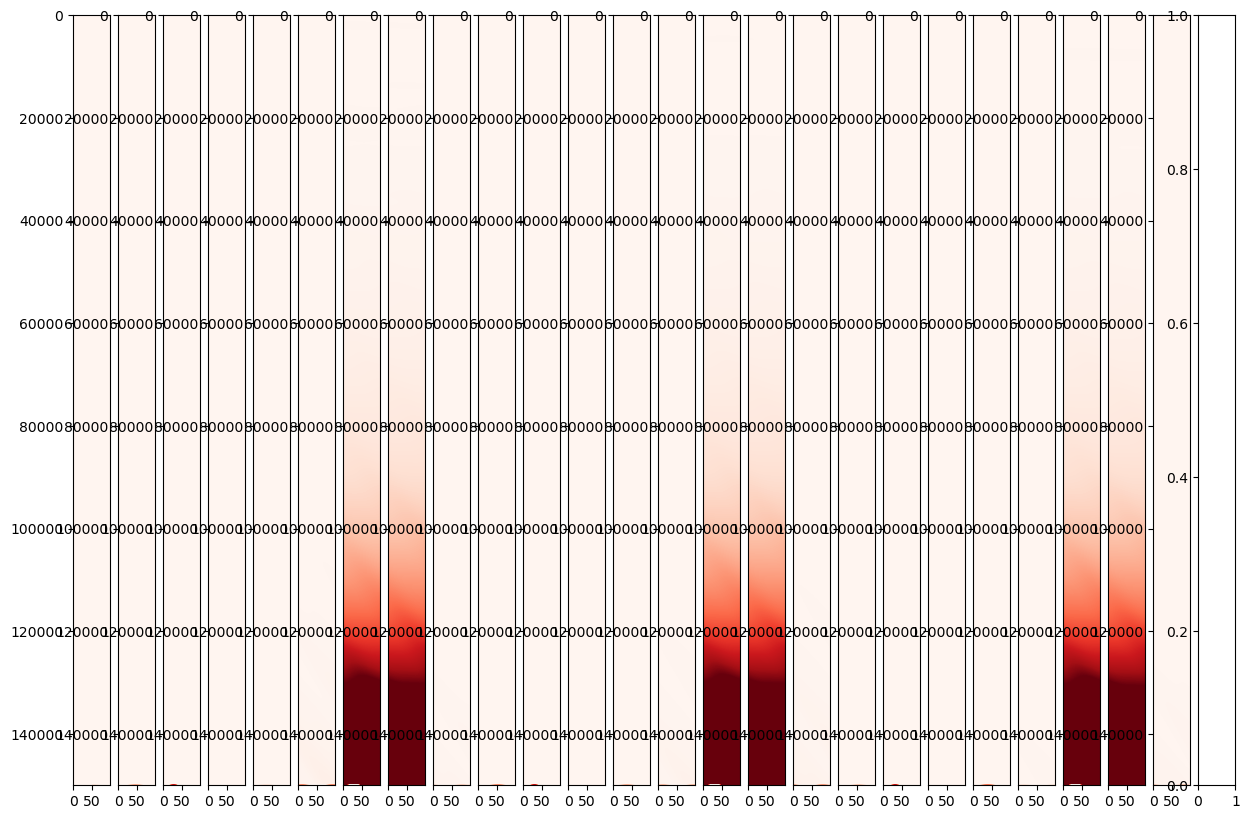

In [26]:
f, ax = plt.subplots(1,N_seg, figsize=(15,10)) 

vmax_val = np.max(np.real(ez_tab[0,:,:]))

for ii in range(N_seg-1):
    ax[ii].imshow(np.real(ez_tab[ii,:,:]), aspect='auto', vmin = 0, vmax = vmax_val , cmap = 'Reds')

In [27]:
Ez = np.zeros((maxTime-1,N_seg), dtype=complex)
# yf = np.zeros((maxTime-1,N_seg), dtype=complex)
windowed_signal = np.zeros((maxTime-1,N_seg), dtype=complex)
spectrum = np.zeros((maxTime-1, N_seg), dtype=complex)


for ii in range(N_seg-1):
    filename = f"data/ez_tab_ssh{ii:04d}.csv"
    df = pd.read_csv(filename)
    # print(df.shape)
    Ez[:,ii] = df.iloc[:,60]   #all rows of the 10th spatial point
   
    Ez[:,ii] -= np.mean(Ez[:,ii])
    
    spectrum[:,ii] = np.fft.fft(Ez[:,ii])
    
    # yf[:,ii] = np.abs(np.fft.fft(Ez[:,ii]))
    # dt = 1e-15    # your time step [s] (adjust to your simulation)

    # Apply Hann window
    # Ez[:,ii] = Ez[:,ii] - np.mean(Ez[:,ii])  #subtracting the average
    # window = np.hanning(N)
    # windowed_signal[:,ii] = Ez[:,ii] * window
    
    # fft_vals = np.fft.fft(windowed_signal[:,ii])
    # fft_vals = fft_vals / N #normalising by the number of samples
    # spectrum[:, ii] = fft_vals   # store in column
N = len(Ez[:,0])
freqs = np.fft.fftfreq(N, del_t)
mask = freqs >= 0
freqs = freqs[mask]
spectrum = np.abs(spectrum[mask,:])


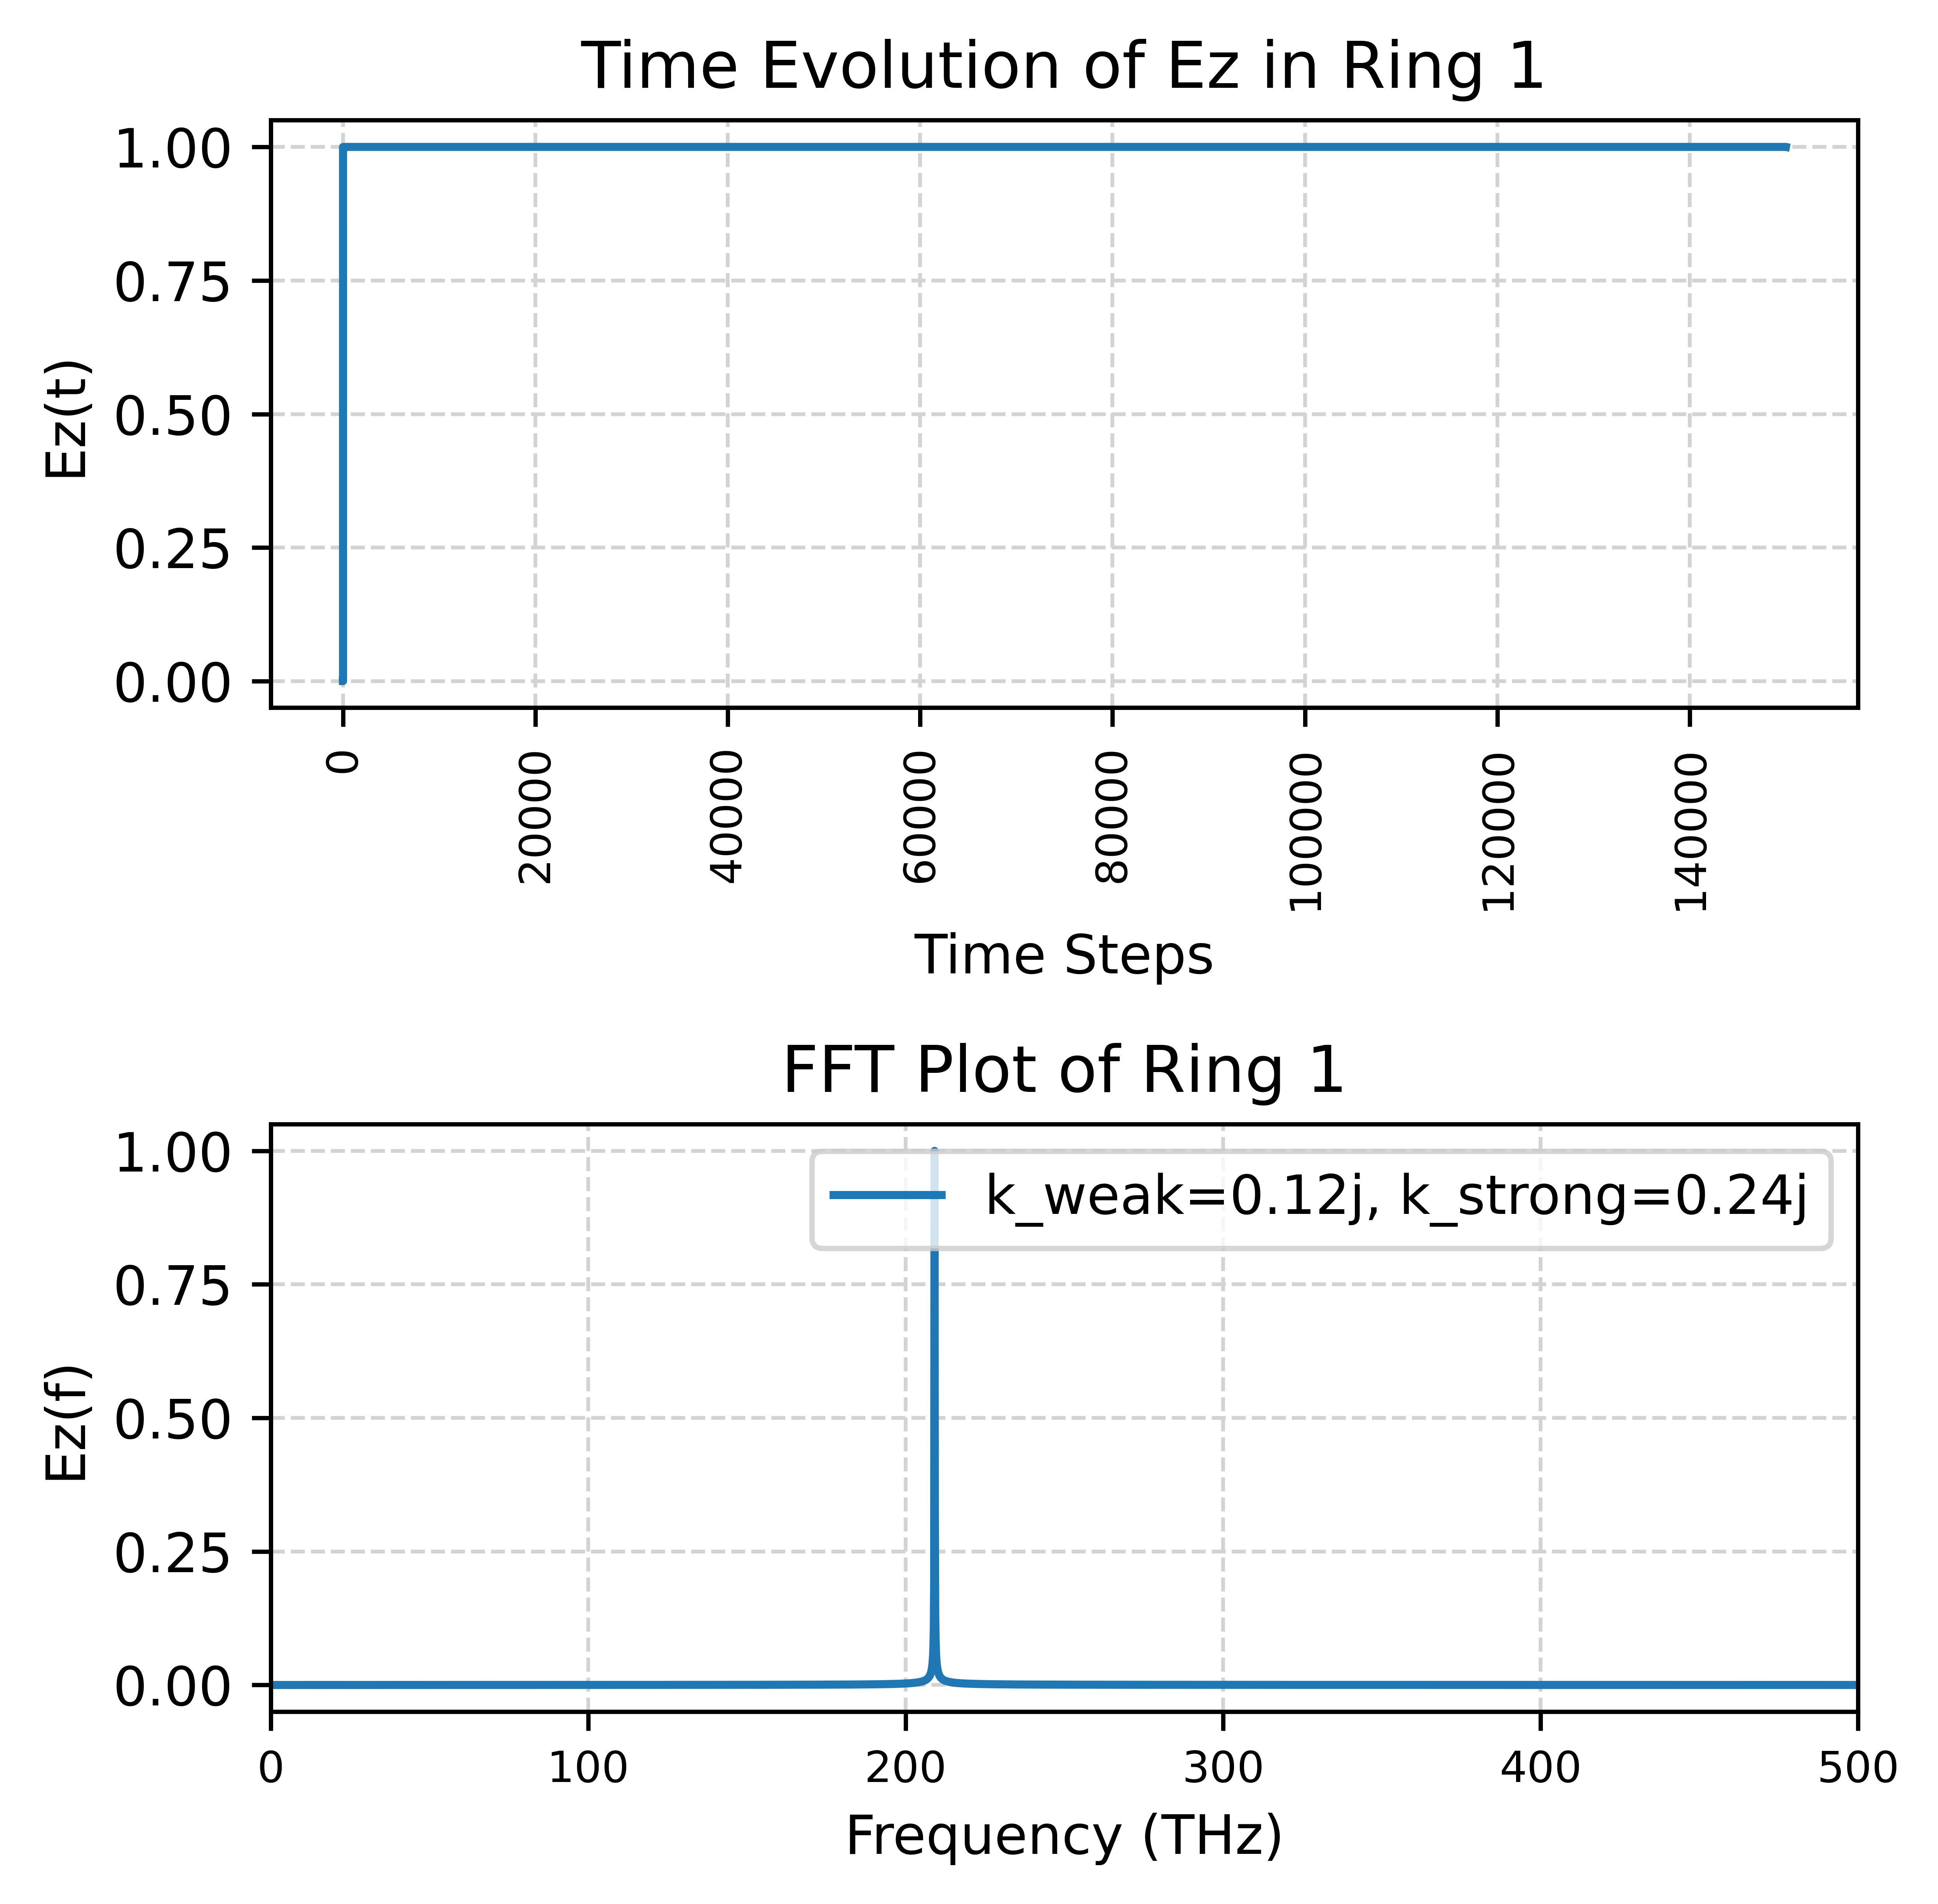

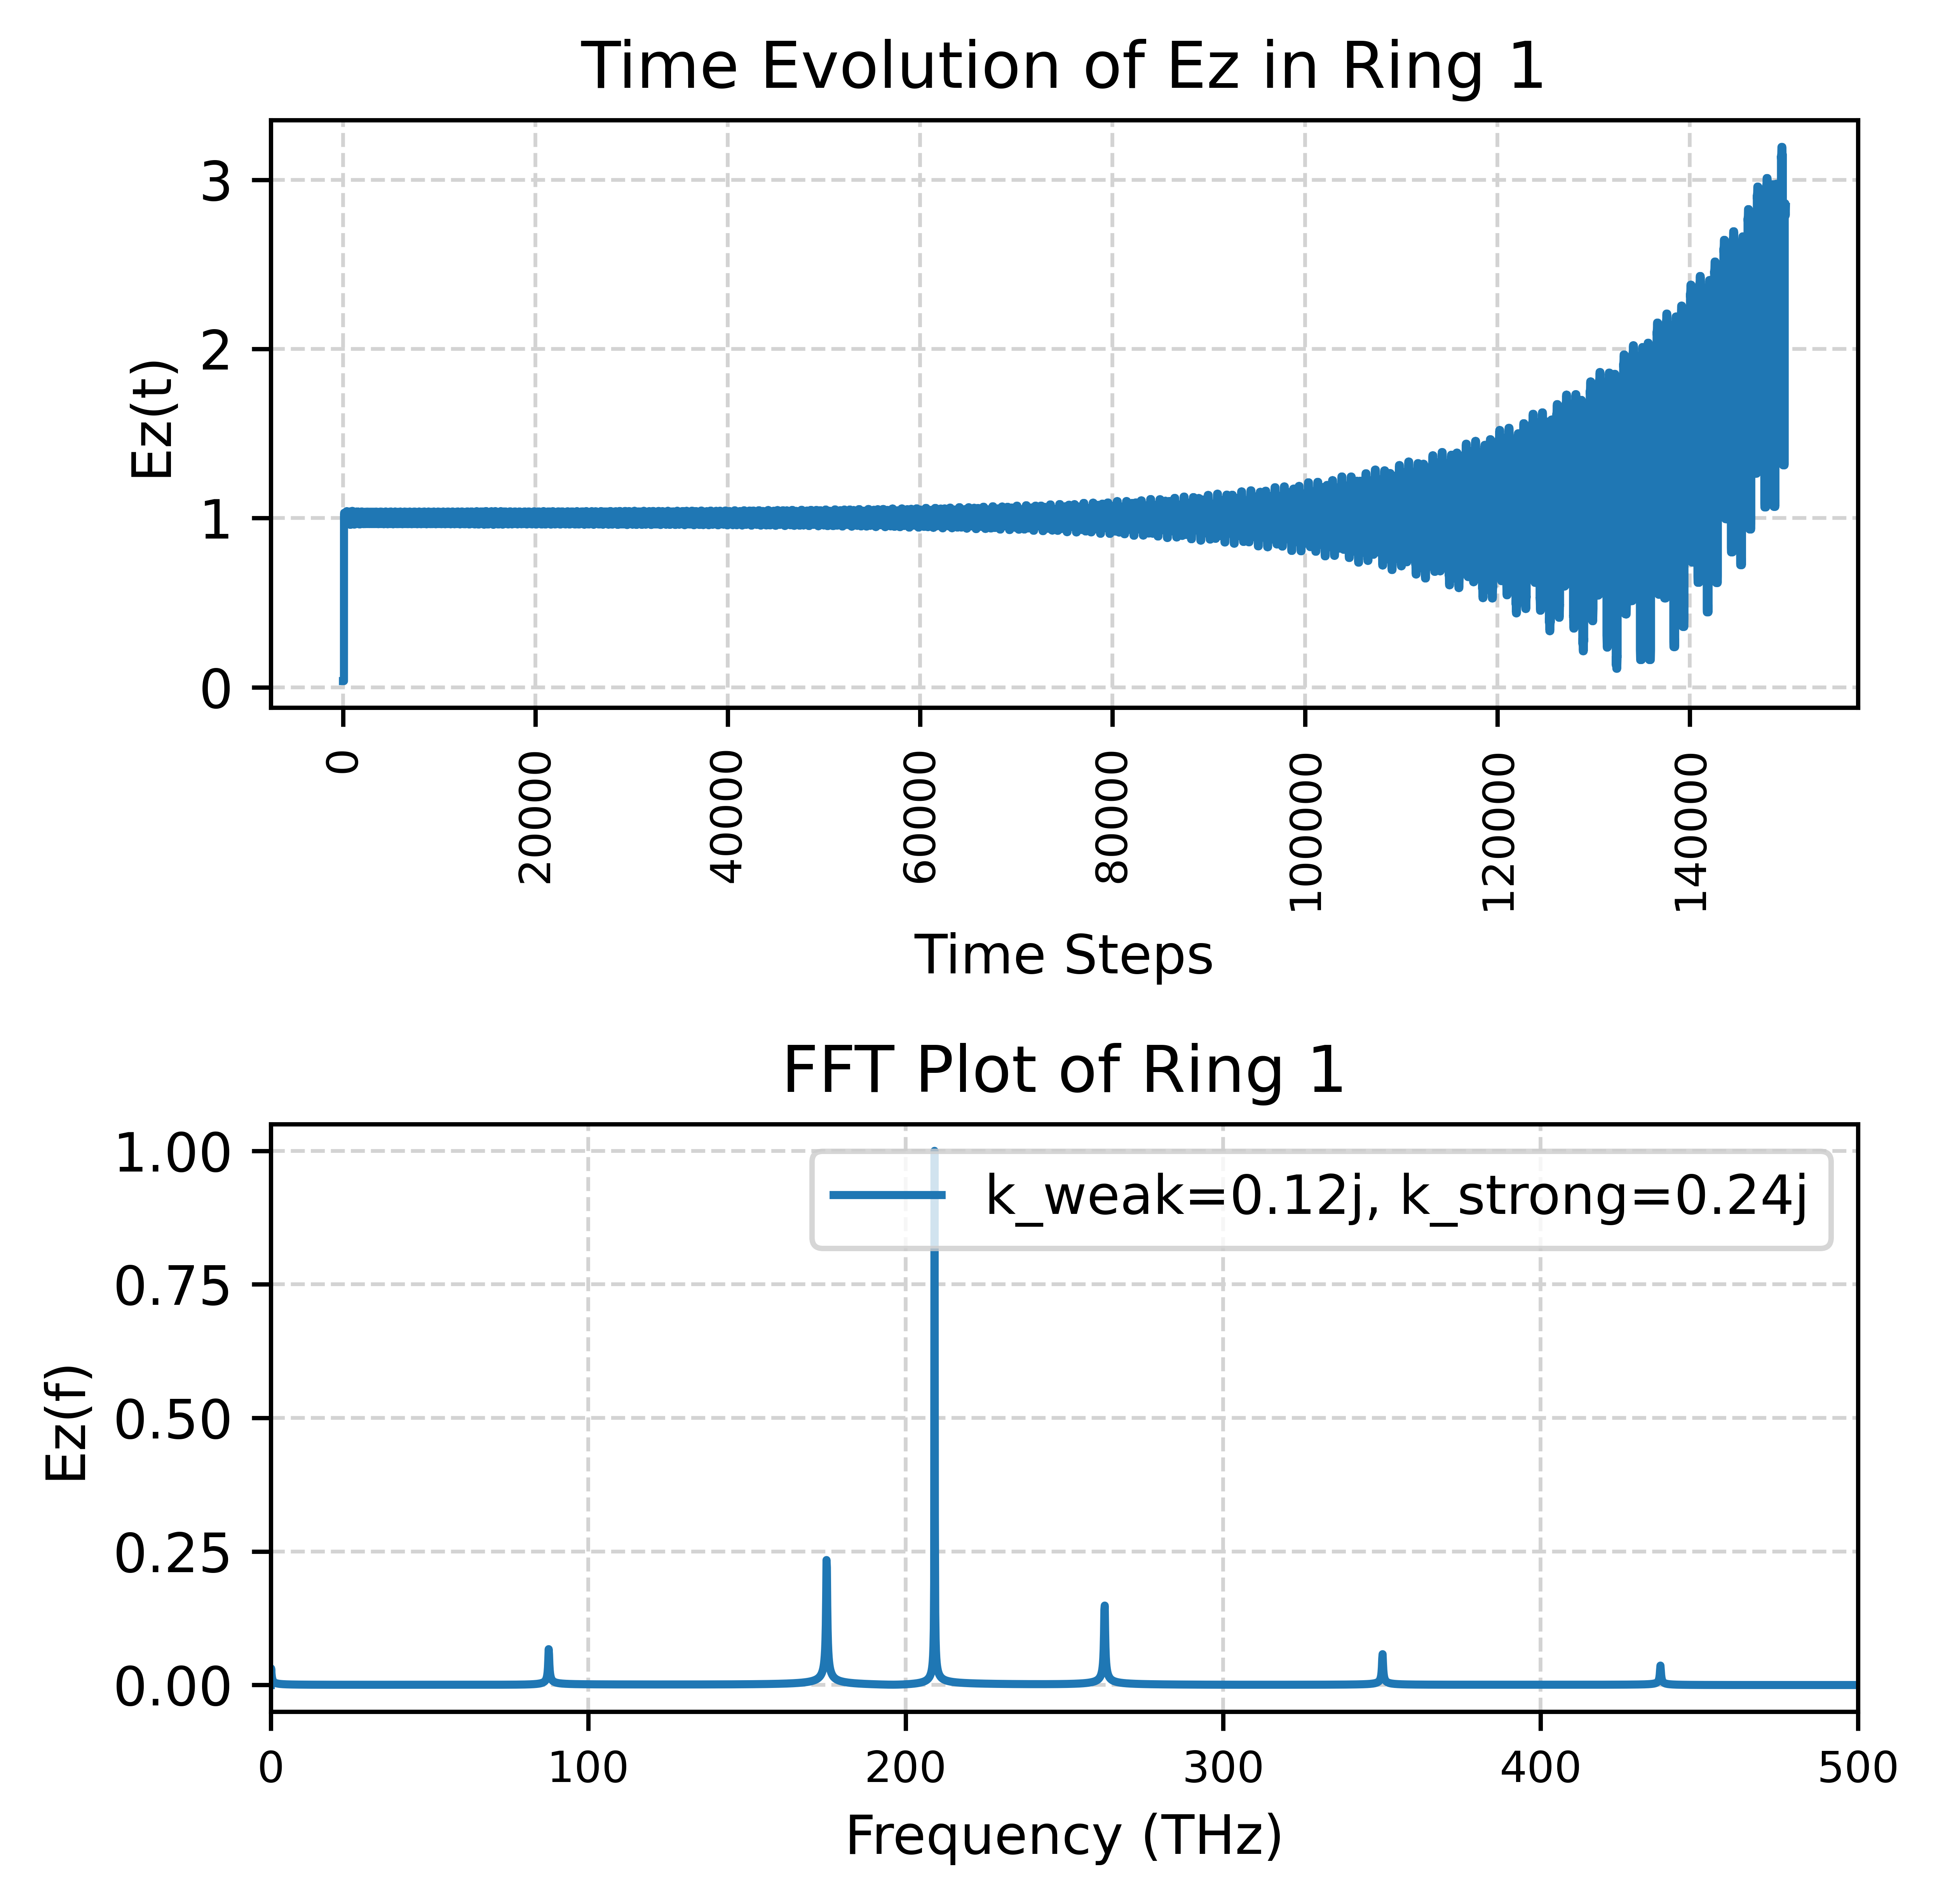

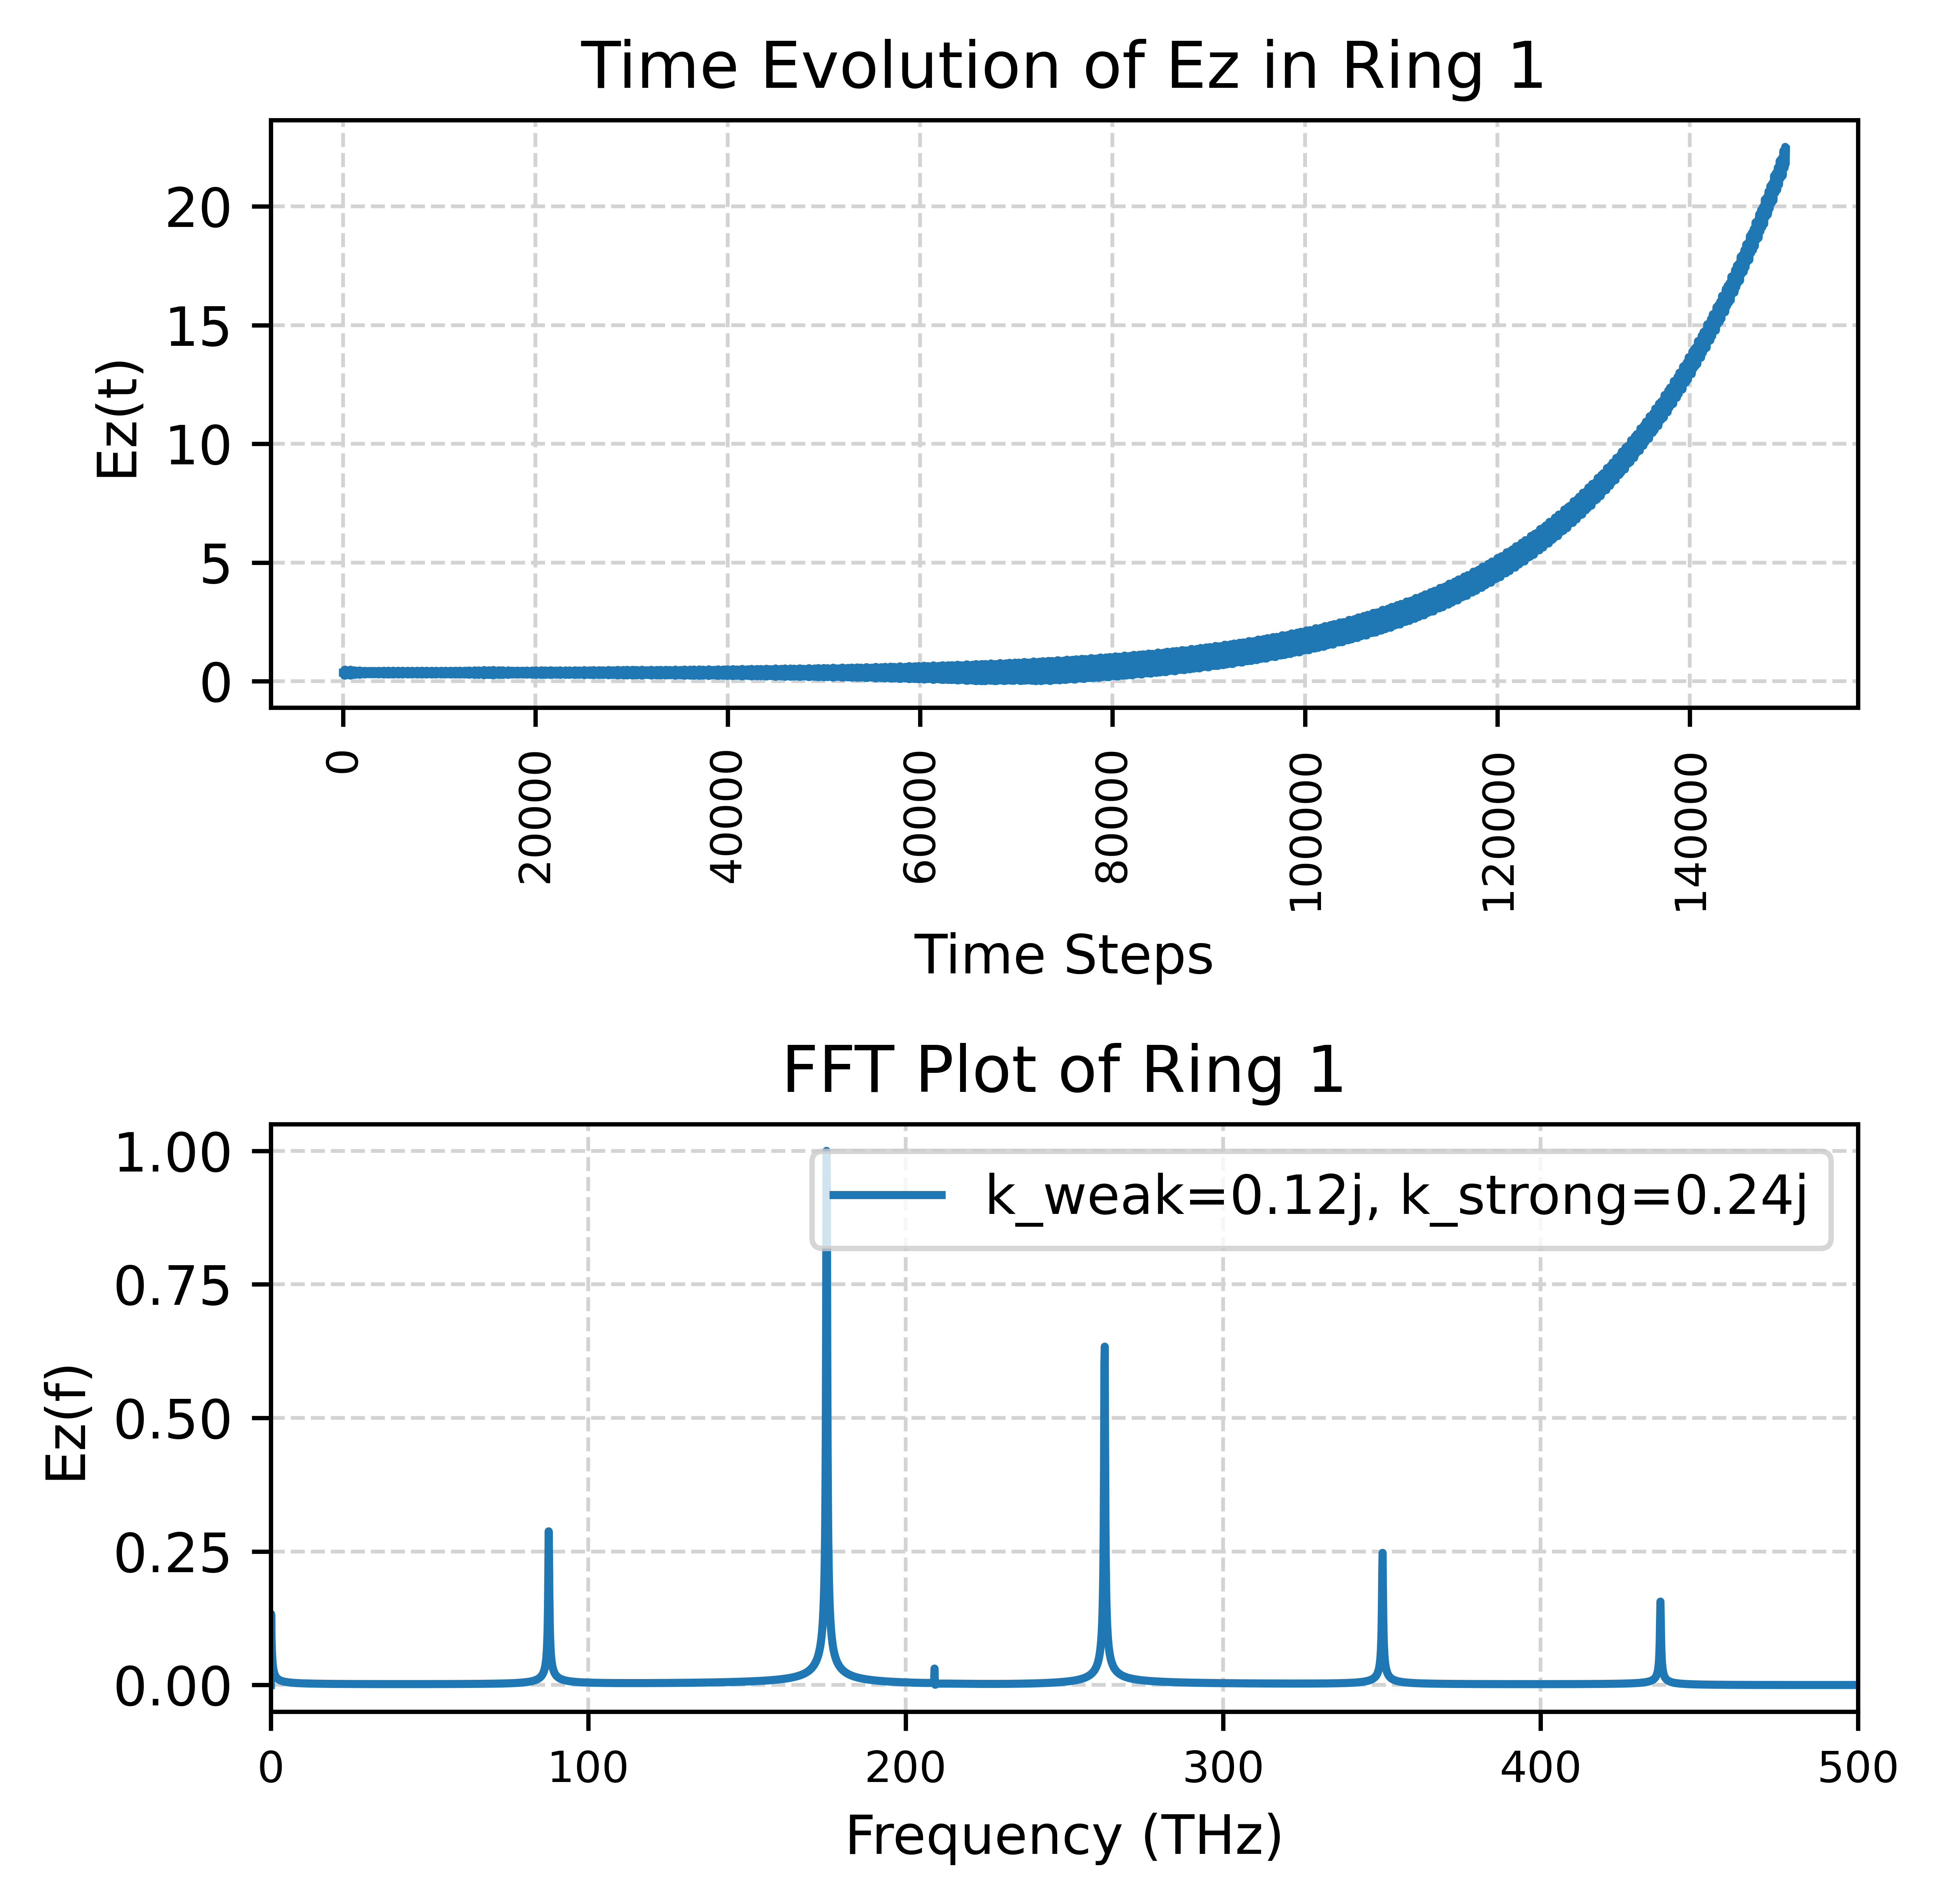

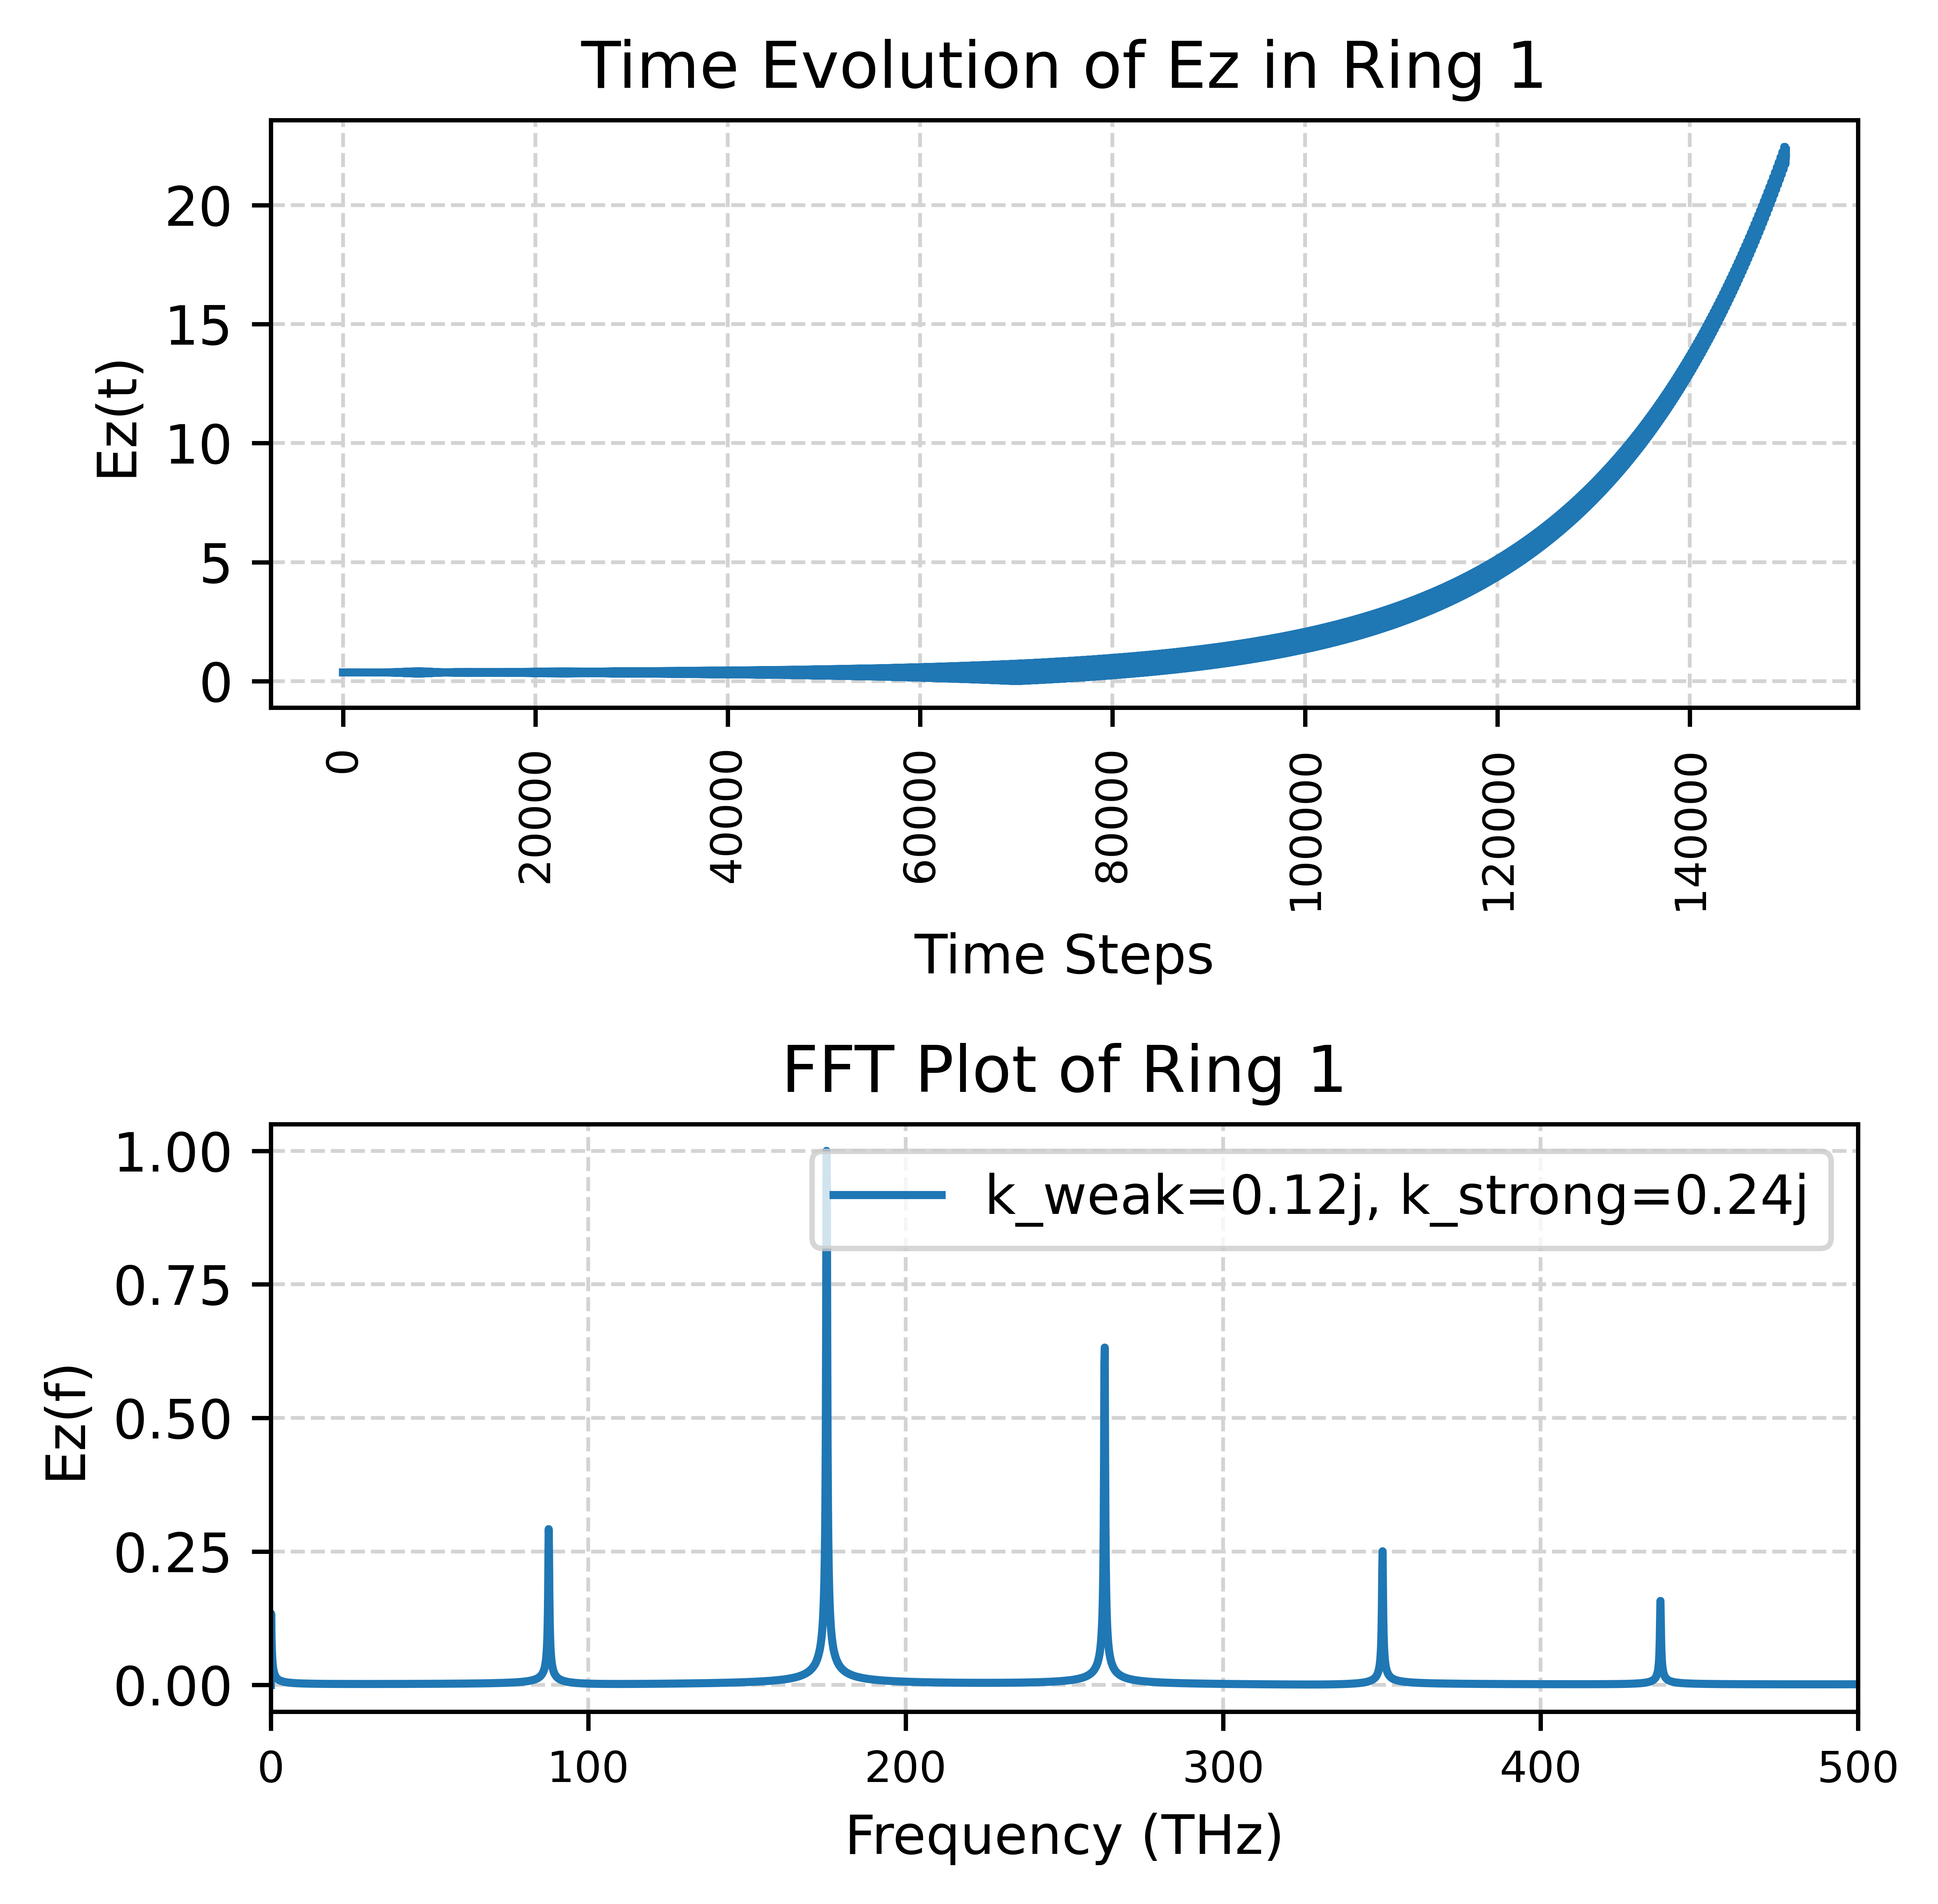

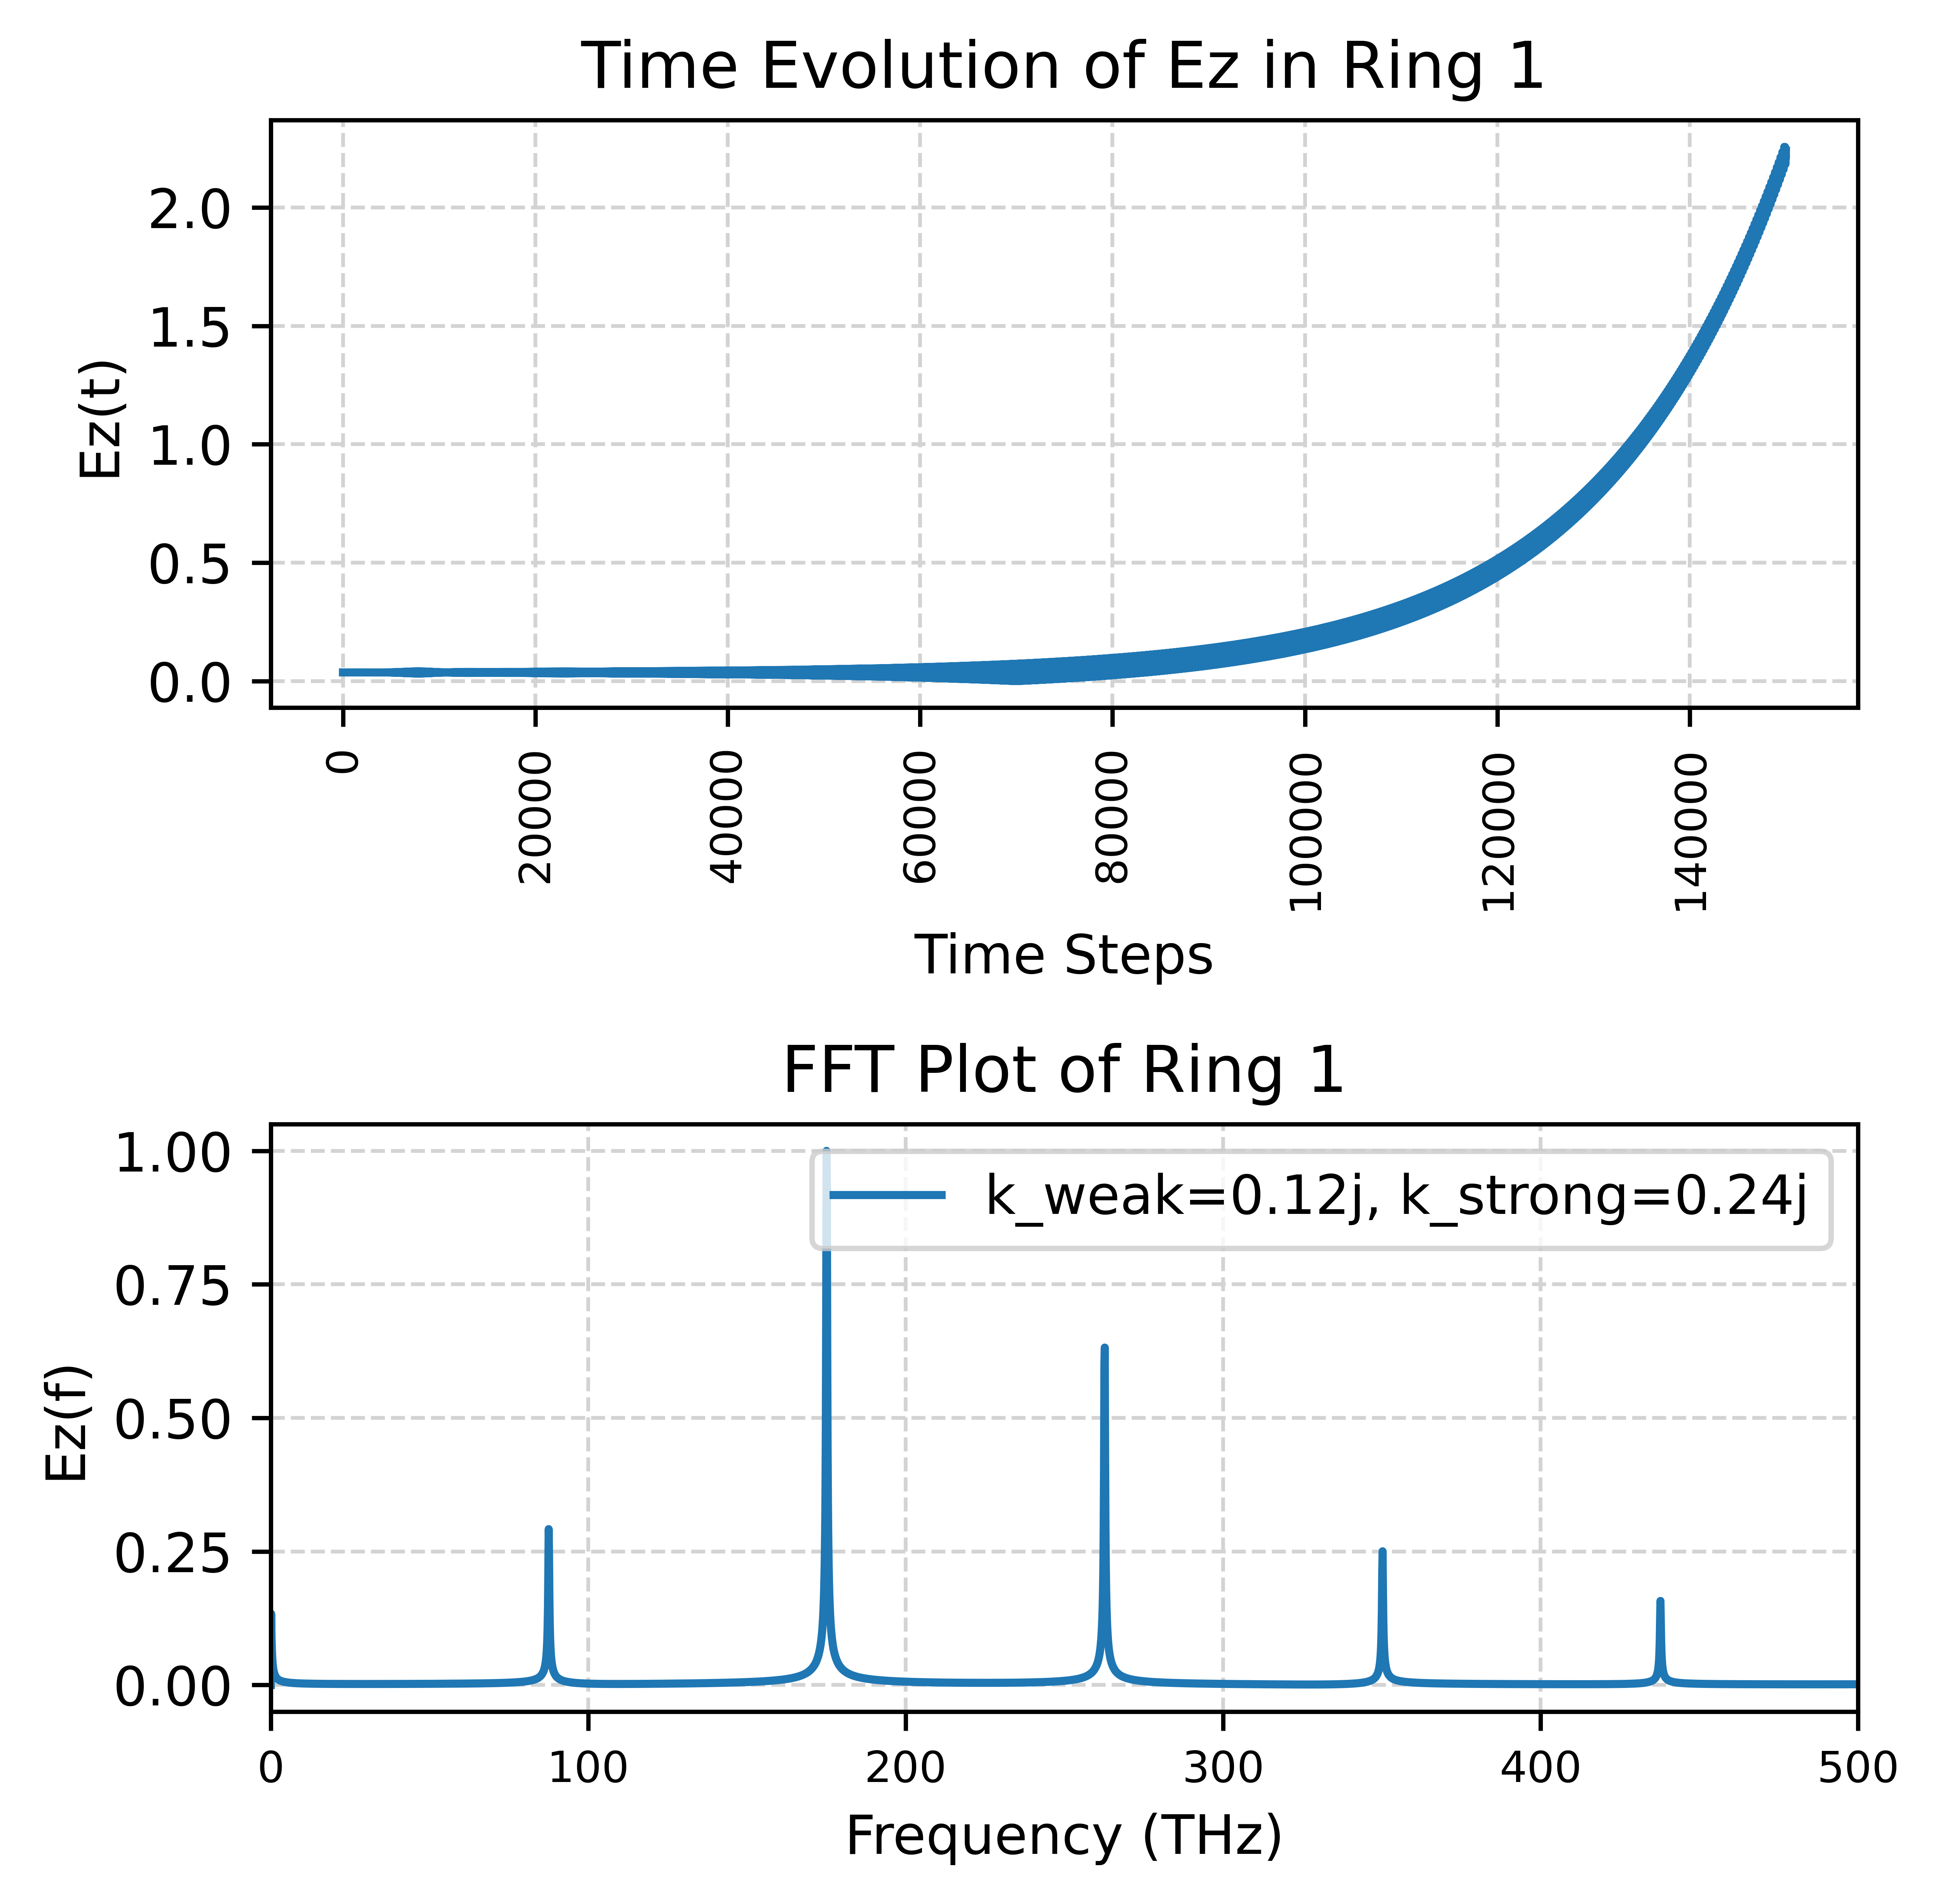

In [37]:
from cProfile import label
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
from numpy import linspace
from sympy import rotations

ports = [0,1,2,N_seg-3, N_seg-2]
for ii in ports:
    # plt.figure(figsize=(5,5), dpi=1000)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5), dpi = 1000)

    # First subplot
    ax1.plot(np.abs(Ez[:, ii]), label="")
    ax1.set_ylabel("Ez(t)")
    ax1.set_xlabel("Time Steps")

    # Integer ticks
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))


    # Rotate ticks safely
    ax1.tick_params(axis='x', rotation=90, labelsize = 8)
    # ax1.set_xticklabels(ax1.get_xticks(), rotation=90)
    # ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))
    ax1.set_title(f"Time Evolution of Ez in Ring 1")
    ax1.grid(True, color="lightgrey", linestyle="--", linewidth=0.7)

    # Second subplot
    ax2.plot(freqs, np.abs(spectrum[:, ii]/ np.max(spectrum[:, ii])), label= f"k_weak={np.abs(kappa_alt[0]):.2f}j, k_strong={np.abs(kappa_alt[1]):.2f}j")
    ax2.set_xlim(0e14, 5e14)
    # ax2.set_ylim(0,2)

    # Apply formatter here
    ax2.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f"{x/1e12:.0f}")
    )

    ax2.set_xlabel("Frequency (THz)")
    ax2.set_ylabel("Ez(f)")
    ax2.tick_params(axis='x', labelsize = 8)
    ax2.set_title(f"FFT Plot of Ring 1")
    ax2.grid(True, color="lightgrey", linestyle="--", linewidth=0.7)


    plt.tight_layout()
    plt.legend()
    plt.show()

In [29]:
from scipy.signal import find_peaks

res_freq = []
signal = spectrum[:,2] #taking the through port

peaks, _ = find_peaks(signal)

res_freq = freqs[peaks]/1e12

# # Example: take one probe (say ii=0)
# spec = np.abs(spectrum[:, 1])
# spec /= np.max(spec)  # normalize

# # find peaks above 10% of max, with min spacing
# peaks, _ = find_peaks(spec, height=0.1, distance=10)

# # Extract resonant freqs in Hz
# resonant_freqs = freqs[peaks]

# # Convert to THz for readability
# resonant_freqs_THz = resonant_freqs / 1e12

print("Resonant frequencies (THz):", res_freq)

Resonant frequencies (THz): [1.12647951e-01 8.75274576e+01 1.75054915e+02 2.09074596e+02
 2.11778147e+02 2.62695021e+02 3.50222478e+02 4.37749936e+02
 5.25277393e+02 6.12804851e+02 7.00444956e+02 7.87972414e+02
 8.75499872e+02 9.63027329e+02 1.05055479e+03 1.13819489e+03
 1.22572235e+03 1.31324981e+03 1.40077726e+03 1.48830472e+03
 1.57594483e+03 1.66347229e+03 1.75099974e+03 1.83852720e+03
 1.92605466e+03 2.01369476e+03 2.10122222e+03 2.18874968e+03
 2.27627714e+03 2.36380459e+03 2.45144470e+03 2.53897216e+03
 2.62649961e+03 2.71402707e+03 2.80155453e+03 2.88919464e+03
 2.97672209e+03 3.06424955e+03 3.15177701e+03 3.23930447e+03
 3.32683192e+03 3.41447203e+03 3.50199949e+03 3.58952694e+03
 3.67705440e+03 3.76458186e+03 3.85222196e+03 3.93974942e+03
 4.02727688e+03 4.11480434e+03 4.20233179e+03 4.28997190e+03
 4.37749936e+03 4.46502682e+03 4.55255427e+03 4.64008173e+03
 4.72772184e+03 4.81524929e+03 4.90277675e+03 4.99030421e+03
 5.07783167e+03 5.16547177e+03 5.25299923e+03 5.34052669e

In [30]:
# indices = [0,1,N_seg-2]
# labels = ["Input", "Through", "Drop"]
# for ii,i in zip(indices, labels):
#     figure(figsize=(20,10), dpi=80)
#     plt.subplot(2,1,1)
#     plt.plot(np.abs(Ez[:,ii]), label={i})
#     plt.title("Temporal Evolution")
#     plt.xlabel("time")
#     plt.ylabel("Ez(t)")
#     plt.legend()
#     plt.subplot(2,1,2)
#     plt.plot(freqs,np.abs(yf[:,ii]/(yf[:,0])), label={i})
#     plt.xlim([0.4e16,0.8e16])  #keep the x lim around the resonant frequency
#     # plt.ylim([0,0.5])
#     plt.title("Frequency Spectrum")
#     plt.xlabel("frequency")
#     plt.ylabel("Ez(f)")
#     plt.legend()
#     plt.show()

(26, 150000, 100)
26


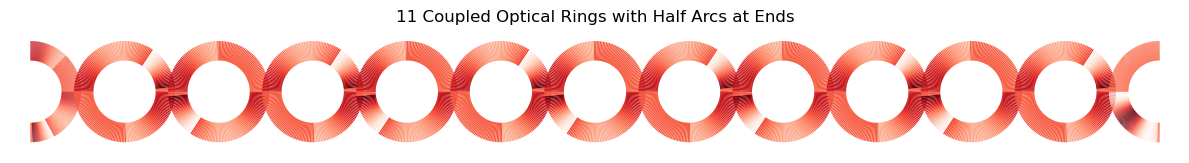

In [31]:
# Parameters
ez_tab_ordered = np.zeros((N_seg, maxTime, SIZE), dtype = complex)
for ring in range(rings_no):
    if ring%2 == 0: #even segment
        ez_tab_ordered[(2*ring),:,:] = ez_tab[2*ring + 1,:,:]
        ez_tab_ordered[(2*ring)+1,:,:] = ez_tab[2*ring,:,:]
    else:
        ez_tab_ordered[(2*ring),:,:] = ez_tab[2*ring,:,:]
        ez_tab_ordered[(2*ring)+1,:,:] = ez_tab[2*ring + 1,:,:]
        
print(np.shape(ez_tab_ordered))


for tp in range(140000,150000,10000):
    ez_tab_tp = ez_tab_ordered[:,tp,:]      
    plot_field_ring(ez_tab_tp, rings_no)

In [32]:
#while coupling I used different indices so in order for the arc plotting function to stack the electric fields in the order they were coupled, I made this logic.

for ring in range(rings_no):
    if ring%2 ==0:
        print(2*ring, 2*ring +1)
        print(2*ring+1, 2*ring)
    else:
        print(2*ring, 2*ring +1)
        print(2*ring, 2*ring +1)

0 1
1 0
2 3
2 3
4 5
5 4
6 7
6 7
8 9
9 8
10 11
10 11
12 13
13 12
14 15
14 15
16 17
17 16
18 19
18 19
20 21
21 20
22 23
22 23
24 25
25 24


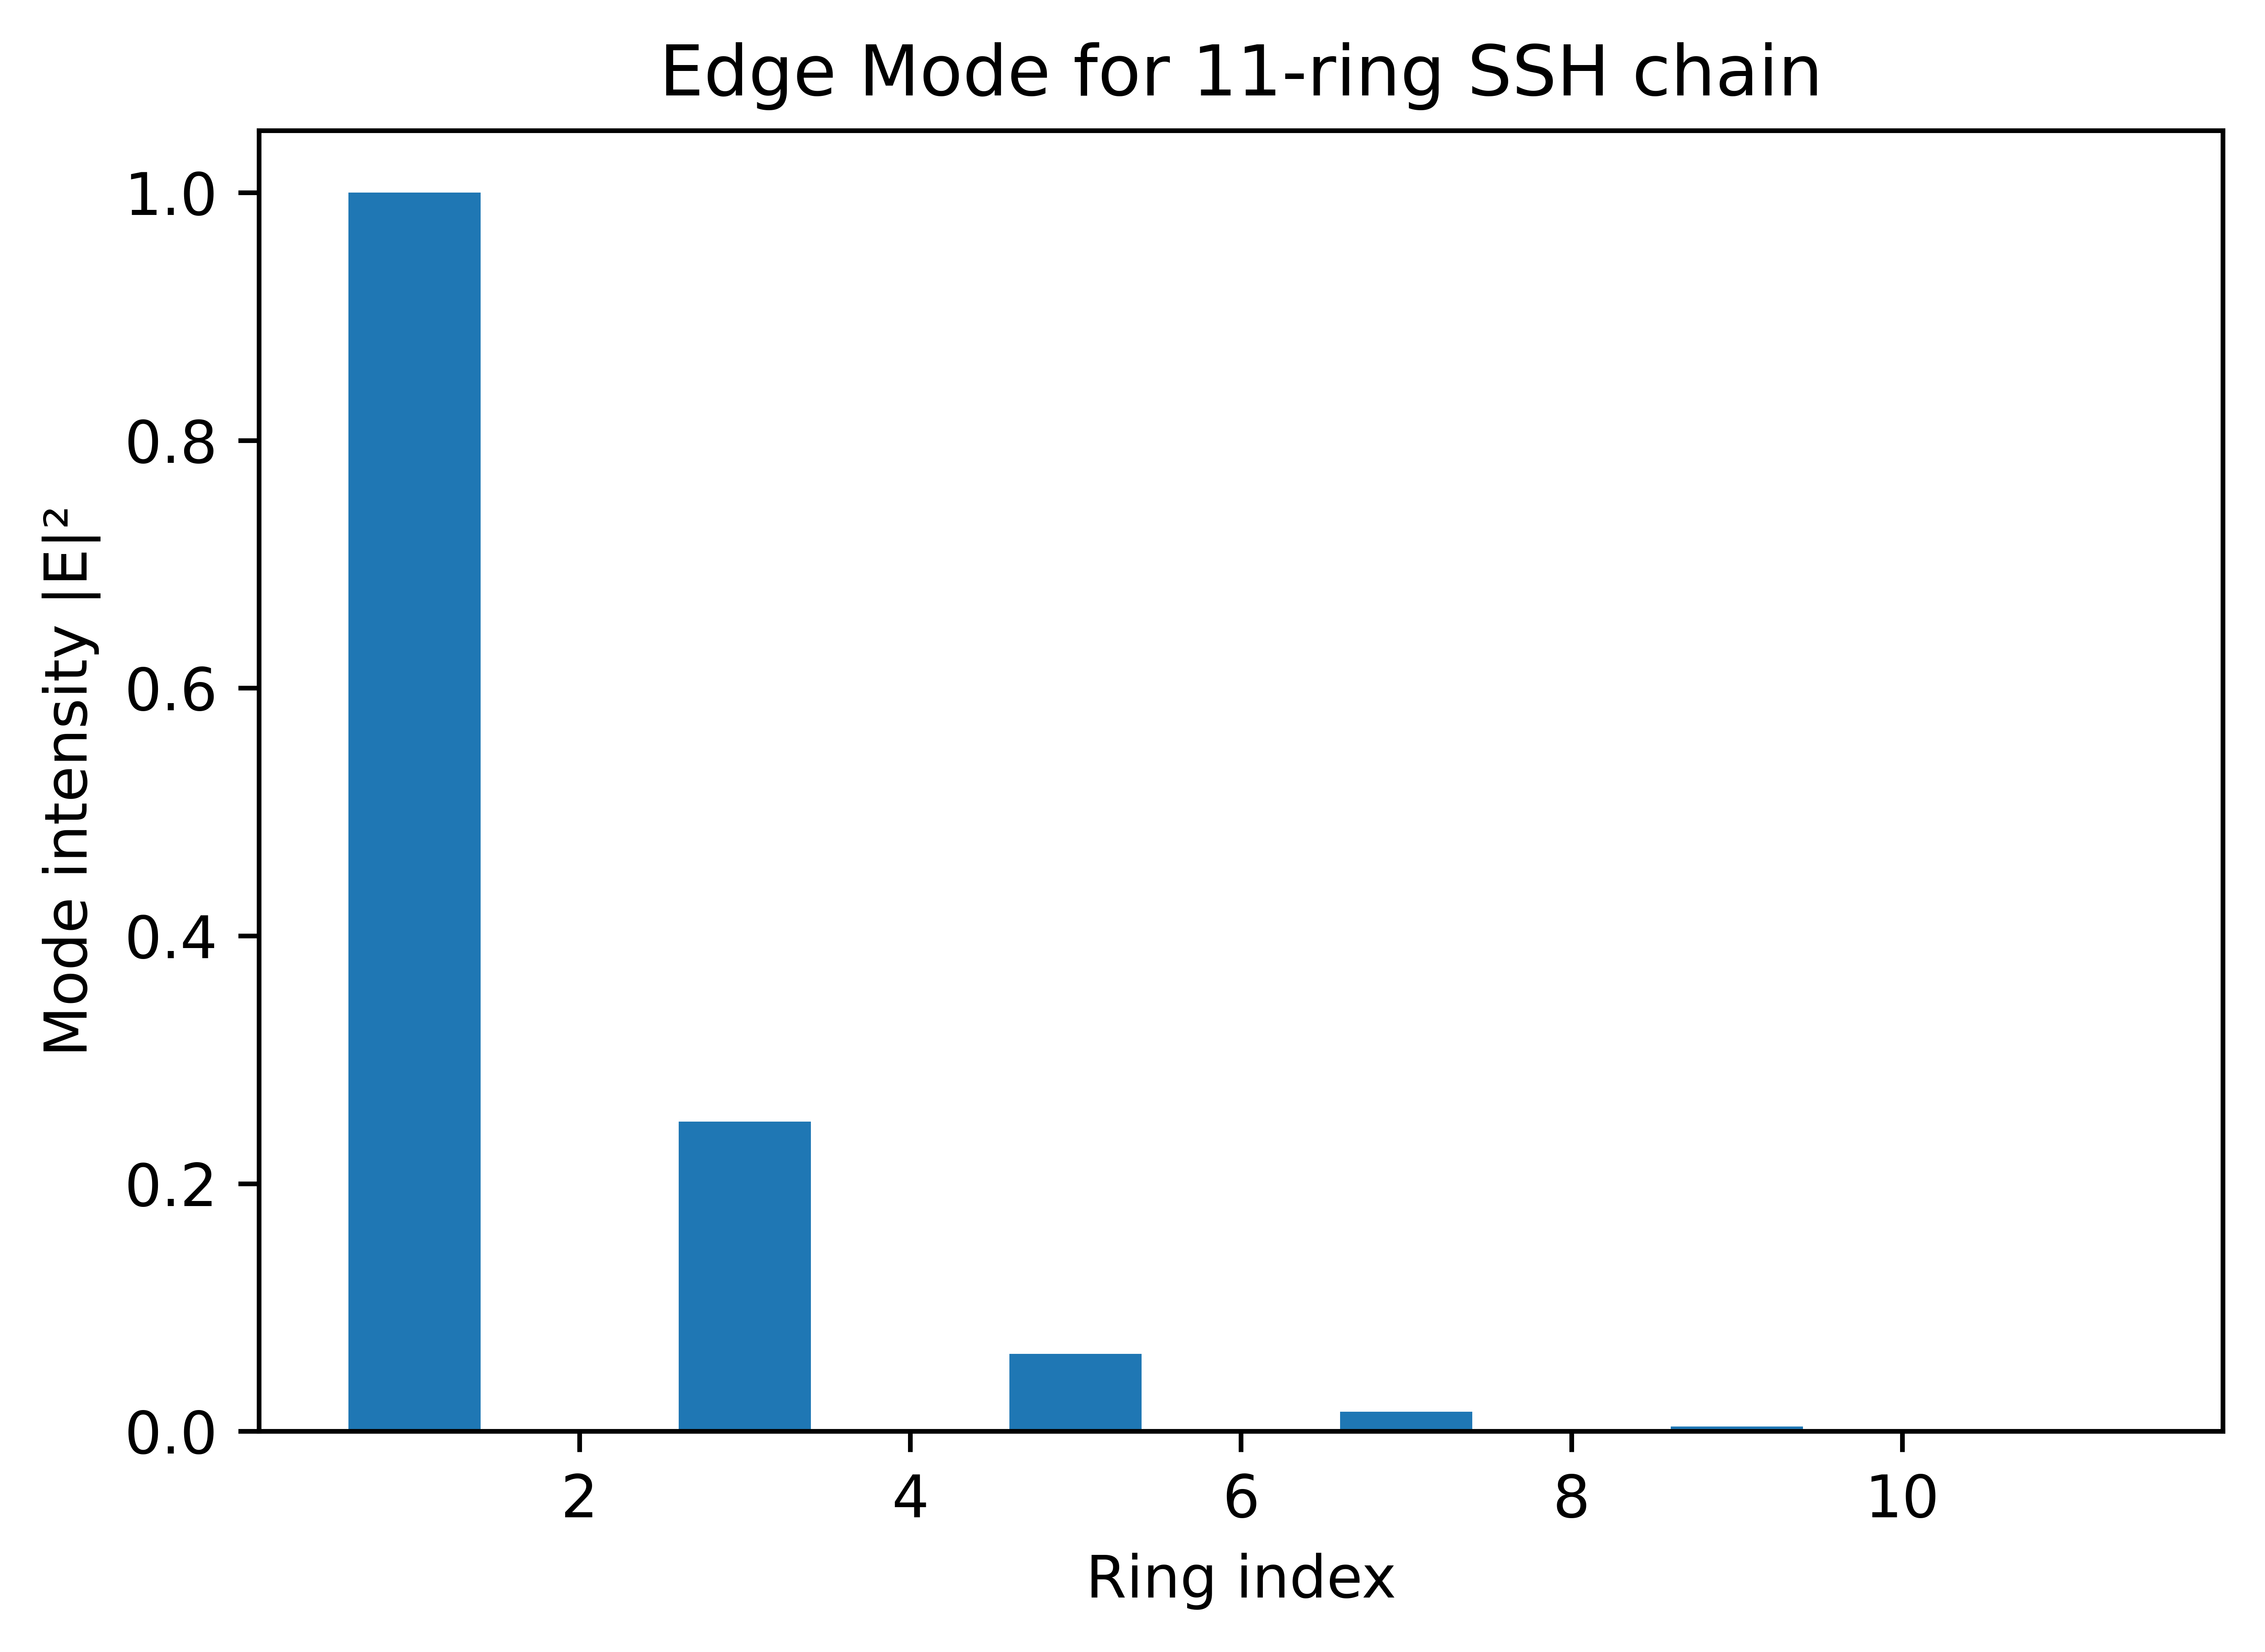

In [40]:


def SSH_Hamiltonian(N_rings, kappa_alt):
    """
    Construct SSH Hamiltonian (tight-binding style) for N rings.
    kappa_alt = [k_w, k_s] are the alternating weak/strong couplings.
    """
    H = np.zeros((N_rings, N_rings), dtype=complex)

    alt = 0  # start with weak
    for i in range(N_rings-1):
        if alt == 0:  # weak
            H[i, i+1] = H[i+1, i] = kappa_alt[0]
        else:         # strong
            H[i, i+1] = H[i+1, i] = kappa_alt[1]
        alt = 1 - alt

    return H

def plot_edge_modes(N_rings=11, kappa_alt=[1j*0.12, 1j*0.24]):
    # Build Hamiltonian
    H = SSH_Hamiltonian(N_rings, kappa_alt)

    # Diagonalize
    eigvals, eigvecs = np.linalg.eigh(H)

    # Sort by real part of eigenvalue
    idx = np.argsort(np.real(eigvals))
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Find mid-gap (edge) mode ~ eigenvalue ~ 0
    mid_index = np.argmin(np.abs(np.real(eigvals)))
    edge_mode = eigvecs[:, mid_index]

    # Normalize
    edge_mode = edge_mode / np.max(np.abs(edge_mode))

    # Plot
    plt.figure(figsize=(6,4), dpi=1000)
    plt.bar(np.arange(1, N_rings+1), np.abs(edge_mode)**2)
    plt.xlabel("Ring index")
    plt.ylabel("Mode intensity |E|²")
    plt.title(f"Edge Mode for {N_rings}-ring SSH chain")
    plt.show()

# Example usage
plot_edge_modes(N_rings=11, kappa_alt=[1j*0.12, 1j*0.24])
